In [4]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
# Pull EIA Data
EIA_KEY = 'S5kBDUycUiKkFCG6uxywpfYtq7IzU7AAhOgoUU4y'


# Initialize parameters
Date = "2010-01-01"
End = None
# API endpoints 
# EIA endpoints

url = 'https://api.eia.gov/v2/petroleum/sum/snd/data/'   
urlTotal = 'https://api.eia.gov/v2/total-energy/data/'

# Parameters

Stocks = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[msn][0]": "COSXPUS",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

StockChange = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[series][0]": "MCRSCUS2",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}


response2 = requests.get(urlTotal, params=Stocks)
data2 = response2.json()
df6 = pd.DataFrame(data2['response']['data'])
df6 = df6[['period', 'value']]
df6.rename(columns={'value': 'Stocks'}, inplace=True)
df6.rename(columns={'period': 'ds'}, inplace=True)
df6['ds'] = pd.to_datetime(df6['ds'])
df6['Stocks'] = pd.to_numeric(df6['Stocks'], errors='coerce')
df_merged = df6

response2 = requests.get(url, params=StockChange)
data2 = response2.json()
df7 = pd.DataFrame(data2['response']['data'])
df7 = df7[['period', 'value']]
df7.rename(columns={'value': 'Stock Change'}, inplace=True)
df7.rename(columns={'period': 'ds'}, inplace=True)
df7['ds'] = pd.to_datetime(df7['ds'])
df7['Stock Change'] = pd.to_numeric(df7['Stock Change'], errors='coerce')
df_merged = pd.merge(df_merged, df7, on='ds', how='outer')

df = pd.read_pickle("ProductionS.pkl")
df = df[['ds','Prod']]
df['ds'] = pd.to_datetime(df['ds'])
df['Prod'] = pd.to_numeric(df['Prod'], errors='coerce')  # Ensure numeric
df_merged = pd.merge(df_merged, df, on='ds', how='outer')

df = pd.read_pickle("ImportS.pkl")
df = df[['ds','Imports']]
df['ds'] = pd.to_datetime(df['ds'])
df['Imports'] = pd.to_numeric(df['Imports'], errors='coerce')  # Ensure numeric
df_merged = pd.merge(df_merged, df, on='ds', how='outer')


df = pd.read_pickle("RefineryD.pkl")
df = df[['ds','Demand']]
df['ds'] = pd.to_datetime(df['ds'])
df = df.rename(columns={'Demand': 'Refinery'})
df_merged = pd.merge(df_merged, df, on='ds', how='outer')

df = pd.read_pickle("ExportD.pkl")
df = df[['ds','Exports']]
df['ds'] = pd.to_datetime(df['ds'])
df_merged = pd.merge(df_merged, df, on='ds', how='outer')



df_merged['Demand'] = df_merged['Refinery'] + df_merged['Exports']
df_merged['Supply'] = df_merged['Prod'] + df_merged['Imports'] 


df_merged.to_pickle("S&D.pkl")
print(df_merged.tail(12))


            ds   Stocks  Stock Change          Prod      Imports  \
176 2024-09-01  415.933          62.0  13527.702000  6455.933000   
177 2024-10-01  423.629         387.0  14022.094000  6355.677000   
178 2024-11-01  421.308          75.0  14385.046000  6577.533000   
179 2024-12-01  413.734        -187.0  13877.831000  6557.323000   
180 2025-01-01  418.782         211.0  13229.518000  6649.355000   
181 2025-02-01  429.786         402.0  14008.885000  6044.964000   
182 2025-03-01  431.688         106.0  14261.269000  5756.032000   
183 2025-04-01  438.666         193.0  14107.833000  5817.300000   
184 2025-05-01  435.018           NaN  14083.351562  6154.742000   
185 2025-06-01      NaN           NaN  14138.632812  6515.645020   
186 2025-07-01      NaN           NaN  13685.968750  6511.597168   
187 2025-08-01      NaN           NaN  13886.073242  6359.775391   

         Refinery      Exports        Demand        Supply  
176  16200.567000  3721.567000  19922.134000  19983.63

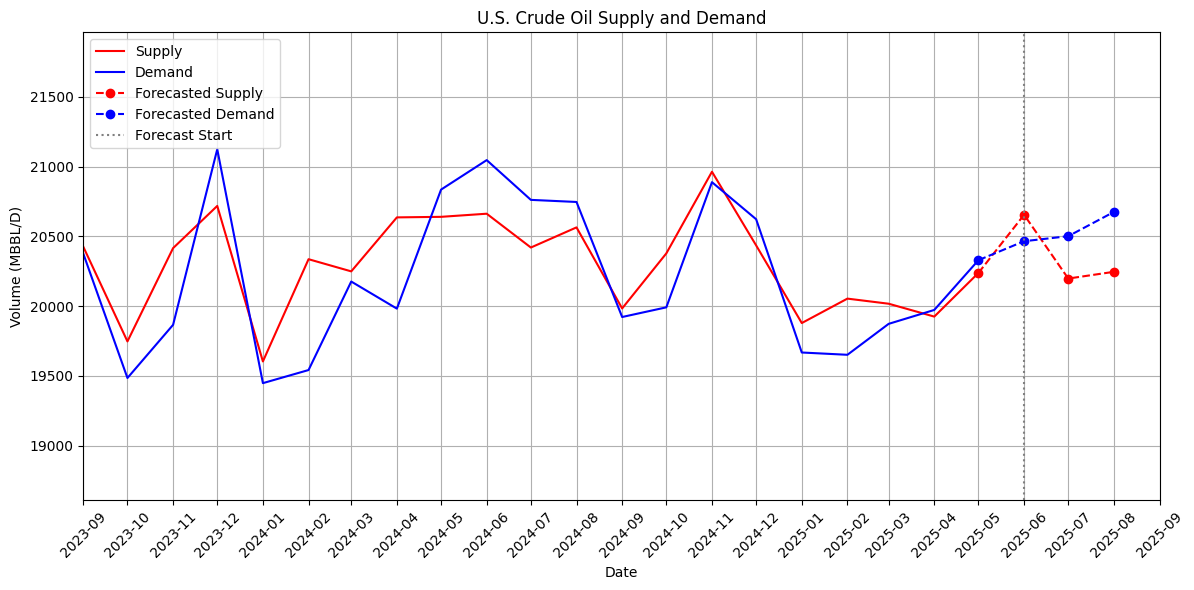

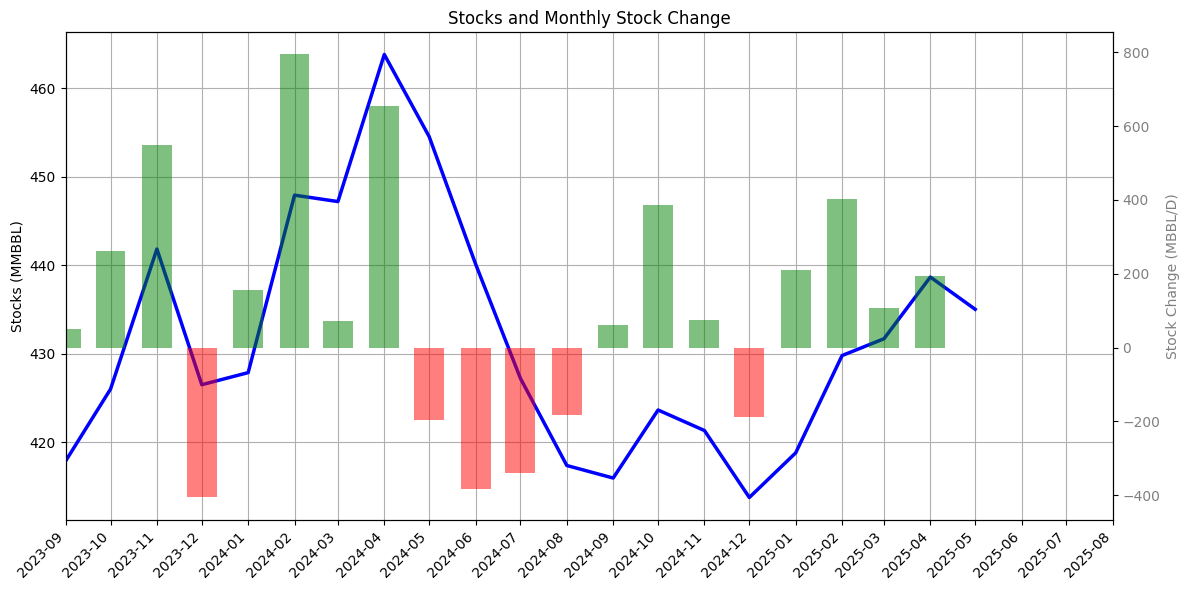

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

# Ensure datetime and sort
df_merged['ds'] = pd.to_datetime(df_merged['ds'])
df_merged = df_merged.sort_values('ds')

# Filter last 24 months
last_date = df_merged['ds'].max()
start_date = last_date - pd.DateOffset(months=23)
df_recent = df_merged[df_merged['ds'] >= start_date].copy()

# Separate historical and forecast (last 3 points)
hist = df_recent.iloc[:-3].copy()
fcast = df_recent.iloc[-3:].copy()

# Extend forecast data by prepending last historical value
fcast_supply = pd.concat([
    hist[['ds', 'Supply']].iloc[[-1]],
    fcast[['ds', 'Supply']]
])
fcast_demand = pd.concat([
    hist[['ds', 'Demand']].iloc[[-1]],
    fcast[['ds', 'Demand']]
])

# Define x-axis limits
x_start = df_recent['ds'].min()
x_end = df_recent['ds'].max() + relativedelta(months=1)

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(hist['ds'], hist['Supply'], color='red', label='Supply')
plt.plot(hist['ds'], hist['Demand'], color='blue', label='Demand')

# Connected forecast lines
plt.plot(fcast_supply['ds'], fcast_supply['Supply'], color='red', linestyle='--', marker='o', label='Forecasted Supply')
plt.plot(fcast_demand['ds'], fcast_demand['Demand'], color='blue', linestyle='--', marker='o', label='Forecasted Demand')

# Forecast start marker
plt.axvline(x=fcast['ds'].iloc[0], color='gray', linestyle=':', label='Forecast Start')

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Expand y-axis range for smoother lines
all_vals = pd.concat([df_recent['Supply'], df_recent['Demand']])
ymin, ymax = all_vals.min(), all_vals.max()
plt.ylim(ymin - 0.5 * (ymax - ymin), ymax + 0.5 * (ymax - ymin))

# Final touches
plt.title('U.S. Crude Oil Supply and Demand')
plt.xlabel('Date')
plt.ylabel('Volume (MBBL/D)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim([x_start, x_end])
plt.show()

# === Assume df_merged and 'ds' already exist ===
df = df_merged.copy()
df['ds'] = pd.to_datetime(df['ds'])

# === Set start and end window ===
end_date = df['ds'].max()
start_date = end_date - relativedelta(months=23)
df = df[(df['ds'] >= start_date) & (df['ds'] <= end_date)]


# === Create Plot ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# === Line plot for Stocks ===
ax1.plot(df['ds'], df['Stocks'], color='blue', label='Stocks', linewidth=2.5)
ax1.set_ylabel("Stocks (MMBBL)", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_title("Stocks and Monthly Stock Change")
ax1.grid(True)

# === Bar plot for Stock Change ===
ax2 = ax1.twinx()
bar_colors = df["Stock Change"].apply(lambda x: 'green' if pd.notna(x) and x >= 0 else 'red')
ax2.bar(df["ds"], df["Stock Change"], color=bar_colors, width=20, alpha=0.5, label="Stock Change")
ax2.set_ylabel("Stock Change (MBBL/D)", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")

# === Fix x-axis: show all dates ===
ax1.set_xticks(df['ds'])  # Ensure all dates show
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')  # Rotate for clarity


# === Extend x-axis range ===
end_date = df["ds"].max()
start_date = end_date - relativedelta(months=23)
extended_end = end_date + relativedelta(months=0)

# Apply updated range AFTER plotting
ax1.set_xlim([start_date, extended_end])
# === Layout ===
fig.tight_layout()
plt.show()


In [7]:
df_merged['Spread'] = df_merged['Supply'] - df_merged['Demand']


# Pull EIA Data
EIA_KEY = 'S5kBDUycUiKkFCG6uxywpfYtq7IzU7AAhOgoUU4y'


# Initialize parameters
Date = "2010-01-01"
End = None
# API endpoints 
# EIA endpoints


 
urlPrice = 'https://api.eia.gov/v2/petroleum/pri/spt/data/'   

WTI = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[series][0]": "RWTC",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

response2 = requests.get(urlPrice, params=WTI)
data2 = response2.json()
df6 = pd.DataFrame(data2['response']['data'])
df6 = df6[['period', 'value']]
df6.rename(columns={'value': 'WTI'}, inplace=True)
df6.rename(columns={'period': 'ds'}, inplace=True)

# Ensure datetime format for merge
df6['ds'] = pd.to_datetime(df6['ds'])
df_merged['ds'] = pd.to_datetime(df_merged['ds'])

# Merge on 'ds' (outer to preserve all rows, or 'inner' for overlap only)
df_merged = pd.merge(df_merged, df6, on='ds', how='outer')

# Optional: sort by date and reset index
df_merged = df_merged.sort_values('ds').reset_index(drop=True)

print(df_merged.tail(20))

            ds   Stocks  Stock Change          Prod      Imports  \
168 2024-01-01  427.857         155.0  12976.566000  6627.323000   
169 2024-02-01  447.929         794.0  13799.080000  6537.103000   
170 2024-03-01  447.206          73.0  14052.783000  6196.194000   
171 2024-04-01  463.842         654.0  14057.629000  6578.033000   
172 2024-05-01  454.548        -195.0  13584.128000  7055.484000   
173 2024-06-01  440.151        -383.0  13997.855000  6664.133000   
174 2024-07-01  427.207        -341.0  13296.927000  7122.839000   
175 2024-08-01  417.350        -182.0  14238.545000  6325.419000   
176 2024-09-01  415.933          62.0  13527.702000  6455.933000   
177 2024-10-01  423.629         387.0  14022.094000  6355.677000   
178 2024-11-01  421.308          75.0  14385.046000  6577.533000   
179 2024-12-01  413.734        -187.0  13877.831000  6557.323000   
180 2025-01-01  418.782         211.0  13229.518000  6649.355000   
181 2025-02-01  429.786         402.0  14008.885

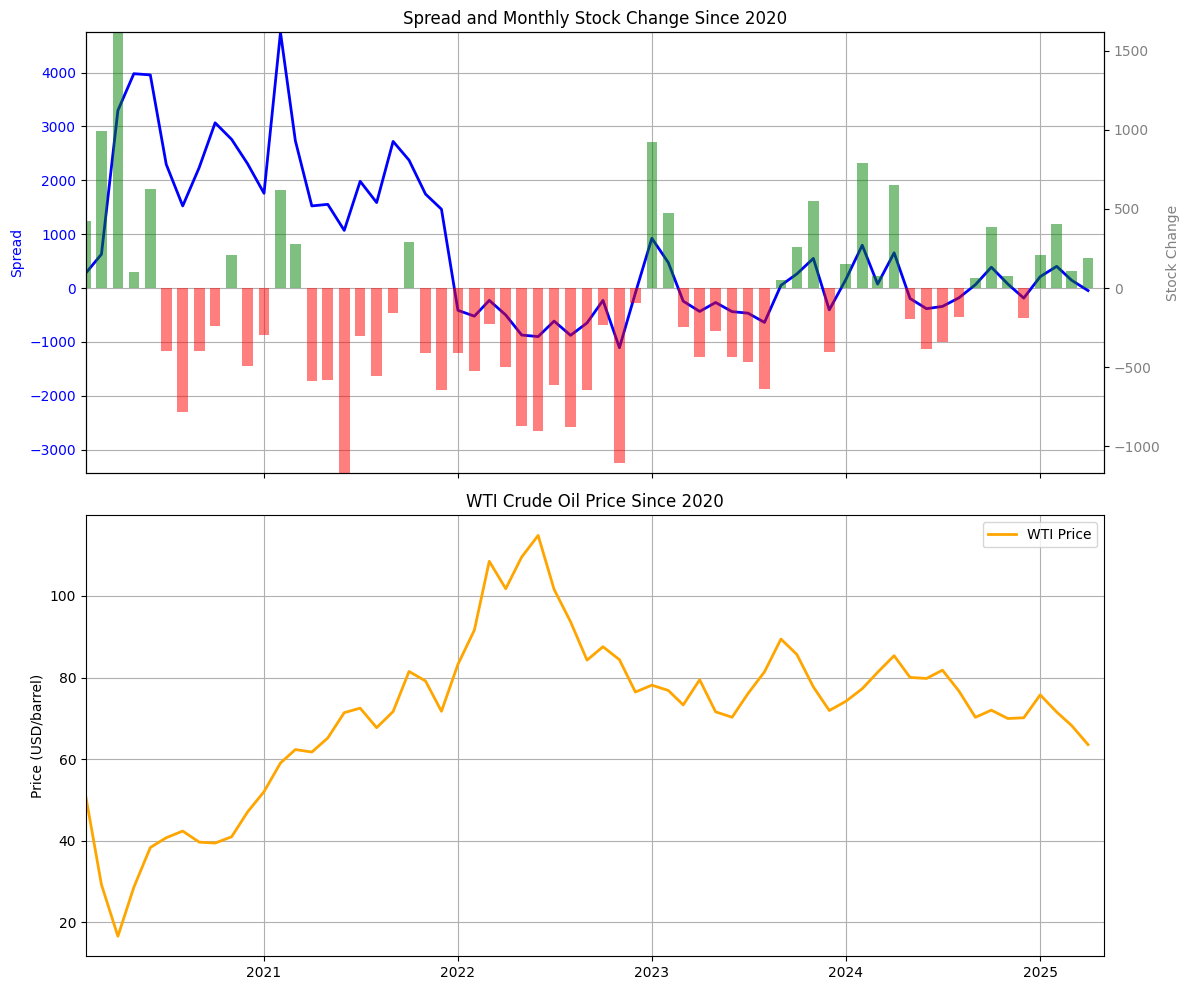

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from dateutil.relativedelta import relativedelta

# === Prepare Data ===
df = df_merged.copy()
df["ds"] = pd.to_datetime(df["ds"])
df = df[df["ds"] >= "2020-01-01"]
df = df.dropna(subset=["WTI", "Spread", "Stock Change"])
df["WTI"] = pd.to_numeric(df["WTI"], errors="coerce")

# === Compute Axis Ranges ===
spread_min, spread_max = df["Spread"].min(), df["Spread"].max()
change_min, change_max = df["Stock Change"].min(), df["Stock Change"].max()

spread_zero_pos = abs(spread_min) / (spread_max - spread_min)
change_zero_pos = abs(change_min) / (change_max - change_min)
target_zero_pos = max(spread_zero_pos, change_zero_pos)

spread_total_range = spread_max / (1 - target_zero_pos)
change_total_range = change_max / (1 - target_zero_pos)

spread_ylim = [-spread_total_range * target_zero_pos, spread_total_range * (1 - target_zero_pos)]
change_ylim = [-change_total_range * target_zero_pos, change_total_range * (1 - target_zero_pos)]

# === Define Date Range ===
start = df["ds"].min()
end = df["ds"].max() + relativedelta(months=1)

# === Create Subplots with Shared X-Axis ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# === Subplot 1: Spread + Stock Change ===
ax1.plot(df["ds"], df["Spread"], color="blue", linewidth=2, label="Spread")
ax1.set_ylabel("Spread", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_ylim(spread_ylim)
ax1.set_title("Spread and Monthly Stock Change Since 2020")
ax1.grid(True)

ax1b = ax1.twinx()
bar_colors = df["Stock Change"].apply(lambda x: "green" if x >= 0 else "red")
ax1b.bar(df["ds"], df["Stock Change"], color=bar_colors, width=20, alpha=0.5)
ax1b.set_ylabel("Stock Change", color="gray")
ax1b.tick_params(axis="y", labelcolor="gray")
ax1b.set_ylim(change_ylim)

# === Subplot 2: WTI Price ===
ax2.plot(df["ds"], df["WTI"], color="orange", linewidth=2, label="WTI Price")
ax2.set_ylabel("Price (USD/barrel)")
ax2.set_title("WTI Crude Oil Price Since 2020")
ax2.grid(True)
ax2.legend()

# === Shared X-axis formatting ===
ax2.set_xlim([start, end])
locator = mdates.YearLocator()
formatter = mdates.DateFormatter('%Y')
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=0)

# === Final Layout ===
plt.tight_layout()
plt.show()
